In [ ]:
# default_exp models


# models
> models to be used in contextual map solvers

In [ ]:
#export
from thompson_sampling.multi_armed_bandits import contextual_categorical_bandit, contextual_categorical_get_optimal_arm, contextual_numerical_bandit
import matplotlib.pyplot as plt
import numpy as np




Bad key "text.kerning_factor" on line 4 in
/home/thomas/anaconda3/envs/pytorch_GPU/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
theta = [0.6, 0.9]
noise = 0.1

np.random.seed(42)

## Categorical
> for logistic regression

### Linear

In [ ]:
#export
from scipy.optimize import minimize
import scipy.stats as stats
import numpy as np



class OnlineLogisticRegression:
    """taken from https://gdmarmerola.github.io/ts-for-contextual-bandits/ """
    
    # initializing
    def __init__(self,n_dim, lambda_ = None, alpha = None):
        
        # the only hyperparameter is the deviation on the prior (L2 regularizer)
        self.lambda_ = lambda_ or 1
        self.alpha = alpha or 1
                
        # initializing parameters of the model
        self.n_dim = n_dim, 
        self.m = np.zeros(self.n_dim)
        self.q = np.ones(self.n_dim) * self.lambda_
        
        # initializing weights
        self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
        
    # the loss function
    def loss(self, w, *args):
        X, y = args
        return 0.5 * (self.q * (w - self.m)).dot(w - self.m) + np.sum([np.log(1 + np.exp(-y[j] * w.dot(X[j]))) for j in range(y.shape[0])])
        
    # the gradient
    def grad(self, w, *args):
        X, y = args
        return self.q * (w - self.m) + (-1) * np.array([y[j] *  X[j] / (1. + np.exp(y[j] * w.dot(X[j]))) for j in range(y.shape[0])]).sum(axis=0)
    
    # method for sampling weights
    def get_weights(self):
      return stats.multivariate_normal(self.m, self.alpha * (self.q)**(-1.0)).rvs()
        #return np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)
    
    # fitting method
    def fit(self, X, y):
        
#         print(X)
        
#         print(f'X {X.shape}')
#         print(f'y {y.shape}')
#         print(f'self w {self.w.shape}')
#         print(f'self m {self.m.shape}')
                
        # step 1, find w
        self.w = minimize(self.loss, self.w, args=(X, y), jac=self.grad, method="L-BFGS-B", options={'maxiter': 20, 'disp':True}).x
        self.m = self.w
        
        # step 2, update q
        P = (1 + np.exp(1 - X.dot(self.m))) ** (-1)
        self.q = self.q + (P*(1-P)).dot(X ** 2)


    def observe(self,X,y):
        self.fit(X,y)
                
    # probability output method, using weights sample
    def predict_proba(self, X, mode='sample'):
        
        # adding intercept to X
        #X = add_constant(X)
        
        # sampling weights after update
        self.w = self.get_weights()
        
        # using weight depending on mode
        if mode == 'sample':
            w = self.w # weights are samples of posteriors
        elif mode == 'expected':
            w = self.m # weights are expected values of posteriors
        else:
            raise Exception('mode not recognized!')
            
            
        X = np.atleast_1d(X)
        w = np.atleast_1d(w)
        #print(f'X shape {X.shape}')
        #print(f'w shape {w.shape}')

        # calculating probabilities
        proba = 1 / (1 + np.exp(-1 * X.dot(w)))
        return np.array([1-proba , proba]).T

No handles with labels found to put in legend.


<Figure size 1350x525 with 0 Axes>

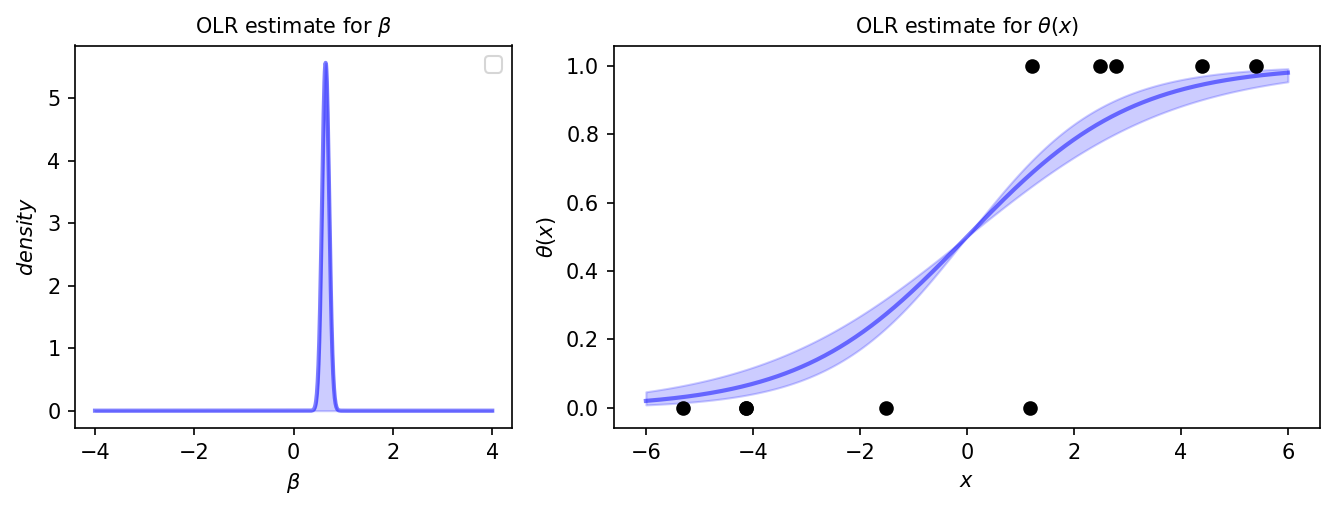

In [ ]:


wee_x = np.random.uniform(-6,6,10)
wee_y = np.array([contextual_categorical_bandit(x,0, theta, noise)[0] for x in wee_x])




# OLR object
online_lr = OnlineLogisticRegression(1, .5, 1)
for i in range(len(wee_y)):
    online_lr.fit(wee_x[i].reshape(-1,1), wee_y[i].reshape(-1,1))
    
    
    
    
    
# closing other figures
plt.close('all')
plt.figure(figsize=[9,3.5], dpi=150)

# let us check the distribution of weights and uncertainty bounds
plt.figure(figsize=[9,3.5], dpi=150)

# plotting the pdf of the weight distribution
X_pdf = np.linspace(-4, 4, 1000)
pdf = stats.norm(loc=online_lr.m, scale=online_lr.q**(-1.0)).pdf(X_pdf)

# range and resolution of probability plot
X_prob = np.linspace(-6, 6, 1000)
p_dist = 1/(1 + np.exp(-X_prob * online_lr.m))
p_dist_plus = 1/(1 + np.exp(-X_prob * (online_lr.m + 2*online_lr.q**(-1.0))))
p_dist_minus = 1/(1 + np.exp(-X_prob * (online_lr.m - 2*online_lr.q**(-1.0))))

# opening subplots
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2, rowspan=1)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=3, rowspan=1)

# plotting distriution of weights
ax1.plot(X_pdf, pdf, color='b', linewidth=2, alpha=0.5)
#ax1.plot([cmab.weights[0][1], cmab.weights[0][1]], [0, max(pdf)], 'k--', label='True $\\beta$', linewidth=1)
ax1.fill_between(X_pdf, pdf, 0, color='b', alpha=0.2)

# plotting probabilities
ax2.plot(X_prob, p_dist, color='b', linewidth=2, alpha=0.5)
ax2.fill_between(X_prob, p_dist_plus, p_dist_minus, color='b', alpha=0.2)
ax2.scatter(wee_x, wee_y, c='k')

# title and comments
ax1.set_title('OLR estimate for $\\beta$', fontsize=10)
ax1.set_xlabel('$\\beta$', fontsize=10); ax1.set_ylabel('$density$', fontsize=10)
ax2.set_title('OLR estimate for $\\theta(x)$', fontsize=10)
ax2.set_xlabel('$x$', fontsize=10); ax2.set_ylabel('$\\theta(x)$', fontsize=10)

ax1.legend(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
online_lr.predict_proba(np.array(wee_x[0]))[0]

0.7497864801605931

In [ ]:
wee_x2 = np.random.uniform(-6,6,[10,2])
[x for x in wee_x2]

[array([-2.49426422, -1.60365788]),
 array([-0.52716019,  3.42211154]),
 array([-3.60391461,  0.17081326]),
 array([ 1.10897483, -5.44259505]),
 array([ 1.29053822, -3.95371052]),
 array([-5.21938088,  5.38662645]),
 array([5.5875844 , 3.70076818]),
 array([-2.34463477, -4.82793463]),
 array([ 2.21079632, -0.71817008]),
 array([-4.53554118, -0.05787708])]

In [ ]:
wee_x2 = np.random.uniform(-6,6,[10,2])
wee_y2 = np.array([contextual_categorical_bandit(x,0, theta, noise)[0] for x in wee_x])




# OLR object
online_lr2 = OnlineLogisticRegression(2, .5, 1)
for i in range(len(wee_y2)):
    online_lr2.fit(wee_x2[i].reshape(1,-1), wee_y2[i].reshape(1,-1))
    
online_lr2.predict_proba(wee_x2[0].reshape(1,-1))[0]

array([0.03904842, 0.96095158])

In [ ]:
wee_x2[i].reshape(1,-1).shape

(1, 2)

## numerical
> for regression


### Linear

from https://www.quantstart.com/articles/Bayesian-Linear-Regression-Models-with-PyMC3/

In [ ]:
#export 


class BayesLinReg:

    def __init__(self, n_features, alpha, beta):
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.mean = np.zeros(n_features)
        self.cov_inv = np.identity(n_features) / self.alpha

    def observe(self, x, y):

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.beta * np.outer(x, x)

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y * x)

        self.cov_inv = cov_inv
        self.mean = mean

        return self
    
    def learn(self,X,y):
        "until refactoring..."
        self.observe(X,y)

    def predict(self, x):

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + x @ w_cov @ x.T

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)

    @property
    def weights_dist(self):
        cov = np.linalg.inv(self.cov_inv)
        return stats.multivariate_normal(mean=self.mean, cov=cov)


class BatchBayesLinReg(BayesLinReg):

    def observe(self, x, y):

        # If x and y are singletons, then we coerce them to a batch of length 1
        x = np.atleast_2d(x)
        y = np.atleast_1d(y)

        # Update the inverse covariance matrix (Bishop eq. 3.51)
        cov_inv = self.cov_inv + self.beta * x.T @ x

        # Update the mean vector (Bishop eq. 3.50)
        cov = np.linalg.inv(cov_inv)
        mean = cov @ (self.cov_inv @ self.mean + self.beta * y @ x)

        self.cov_inv = cov_inv
        self.mean = mean

        return (self.predict(x).mean() - y)**2
    
    def learn(self,X,y):
        "until refactoring..."

        self.observe(X,y)

    def predict(self, x):

        x = np.atleast_2d(x)

        # Obtain the predictive mean (Bishop eq. 3.58)
        y_pred_mean = x @ self.mean

        # Obtain the predictive variance (Bishop eq. 3.59)
        w_cov = np.linalg.inv(self.cov_inv)
        y_pred_var = 1 / self.beta + (x @ w_cov * x).sum(axis=1)

        # Drop a dimension from the mean and variance in case x and y were singletons
        # There might be a more elegant way to proceed but this works!
        y_pred_mean = np.squeeze(y_pred_mean)
        y_pred_var = np.squeeze(y_pred_var)

        return stats.norm(loc=y_pred_mean, scale=y_pred_var ** .5)

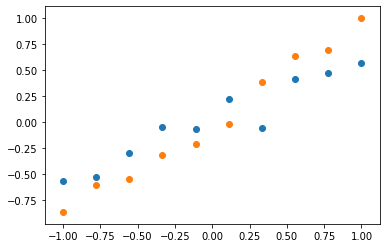

In [ ]:
X = np.linspace(-1,1, 10)
X = np.atleast_2d(X).T
y0 = [contextual_numerical_bandit(x,0,theta,0.1) for x in X]
y1 = [contextual_numerical_bandit(x,1,theta,0.1) for x in X]

plt.scatter(X.squeeze(),y1)
plt.scatter(X.squeeze(),y0)

In [ ]:
np.atleast_2d(X[0]).T == np.atleast_2d(X[0])

array([[ True]])

In [ ]:
X.shape

(10, 1)

In [ ]:
np.atleast_2d(X[0].T).shape

(1, 1)

In [ ]:
bbl = BatchBayesLinReg(n_features = X.shape[1],alpha=0.3, beta=10)

In [ ]:
batch_size = X.shape[0]
n_batches = len(X) // batch_size

batches = zip(
    np.array_split(X, n_batches),
    np.array_split(y0, n_batches)
)

for x_batch, y_batch in batches:
    bbl.observe(np.atleast_2d(x_batch), y_batch)

In [ ]:
y_hat_dist = bbl.predict(X)

In [ ]:
y_hat = y_hat_dist.mean()
y_hat_std = y_hat_dist.std()

In [ ]:
y_hat_dist.rvs()

array([-0.82701683, -1.33850595, -0.54916743, -0.17204244,  0.37254324,
       -0.06865883,  0.02751519,  0.31317877,  0.97693689,  0.97430953])

In [ ]:
y_hat_std

array([0.35027   , 0.3372321 , 0.32711283, 0.32018902, 0.31667035,
       0.31667035, 0.32018902, 0.32711283, 0.3372321 , 0.35027   ])

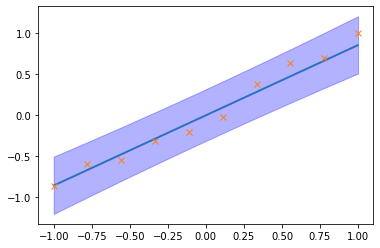

In [ ]:
plt.plot(X.squeeze(),y_hat)
plt.plot(X.squeeze(),y0,'x')
plt.fill_between(X.squeeze(), y_hat, y_hat - y_hat_std, alpha = 0.3,color='blue')
plt.fill_between(X.squeeze(), y_hat, y_hat + y_hat_std, alpha = 0.3,color='blue')


In [ ]:
y_hat_single_dist = bbl.predict(X[0])
y_hat_single_dist.rvs()

-1.0447169889826577

### nonlinear

In [ ]:
#export 
import torch
from torch.autograd import Variable

class SimpleModel(torch.nn.Module):
    def __init__(self,num_input, num_hidden_units=100, p=0.05, decay=0.001, non_linearity=torch.nn.LeakyReLU):
        super(SimpleModel, self).__init__()
        self.dropout_p = p
        self.decay = decay
        self.f = torch.nn.Sequential(
            torch.nn.Linear(num_input,num_hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(num_hidden_units,1)
        )
    def forward(self, X):
        X = Variable(torch.Tensor(X), requires_grad=False)
        return self.f(X)

In [ ]:
X = np.atleast_2d(np.linspace(-1,1,100)).T

y = np.atleast_2d((np.sin(X.squeeze()*3) + np.random.normal(0,.1,100))).T

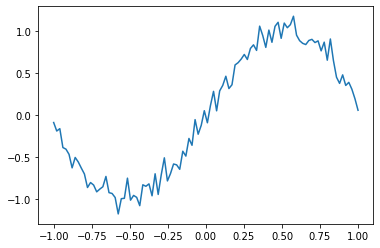

In [ ]:
plt.plot(X,y)

In [ ]:
sm = SimpleModel(1)

In [ ]:
y_hat = sm(X)

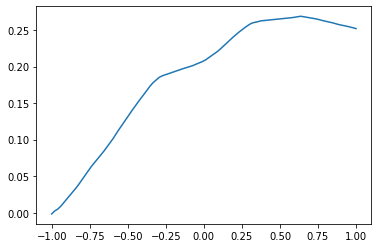

In [ ]:
plt.plot(X,y_hat.detach())

In [ ]:
epochs = 10000

optimizer = torch.optim.SGD(
            sm.parameters(),
            weight_decay=0.01,
            lr=0.001)
criterion = torch.nn.MSELoss()
y_torch = Variable(torch.Tensor(y), requires_grad=False)

for i in range(epochs):
    y_pred = sm(X)
    optimizer.zero_grad()
    loss = criterion(y_pred, y_torch)
    loss.backward()
    optimizer.step()

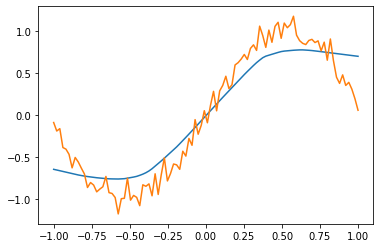

In [ ]:
y_hat = sm(X)
plt.plot(X,y_hat.detach())
plt.plot(X,y)

In [ ]:
#export

# from https://github.com/dennisbakhuis/Tutorials/blob/master/Neural_Network/Artificial_Neural_Network.ipynb
class ActivationDoesNotExist(Exception):
    """Valid activations are sigmoid, tanh, and relu, provided as a string"""
    pass

class InputDimensionNotCorrect(Exception):
    """Need to specify input dimension, i.e. input shape into the first layer"""
    pass

class LossFunctionNotDefined(Exception):
    """Loss function in cost() method not defined"""
    pass


class DenseLayer:
    """
    A class to define fully connected layers.
    """
    
    def __init__(self, inputDimension, units, activation='', randomMultiplier=0.01):
        """
        Constructor:
          inputDimension: number of input features
          units: number of neurons in the layer
          activation: activation function applied to layer
            - options: 'sigmoid', 'tanh', 'relu', ''
          randomMultiplier: multiplier applied to the random weights during initialization
        """
        self.weights, self.bias = self.initialize(inputDimension, units, randomMultiplier)
        if activation == 'sigmoid':
            self.activation = activation
            self.activationForward = self.sigmoid
            self.activationBackward = self.sigmoidGrad
        elif activation == 'relu':
            self.activation = activation
            self.activationForward = self.relu
            self.activationBackward = self.reluGrad
        elif activation == 'tanh':
            self.activation = activation
            self.activationForward = self.tanh
            self.activationBackward = self.tanhGrad
        elif activation != '':
            raise ActivationDoesNotExist
        else:
            self.activation = 'none'
            self.activationForward = self.linear
            self.activationBackward = self.linear
    
    def initialize(self, nx, nh, randomMultiplier):
        """
        Initializes weights randomly:
          nx: number of input features
          nh: number of units
          randomMultiplier: multiplier applied to the random weights during initialization
        returns:
          weights: the randomly initialized weights
          bias: the bias terms
        """
        weights = randomMultiplier * np.random.randn(nh, nx)
        bias = np.zeros([nh, 1])
        return weights, bias

    
    def sigmoid(self, Z):
        """
        Sigmoid activation function
        """
        A = 1 / (1 + np.exp(-Z))
        return A
        
    def sigmoidGrad(self, dA):
        """
        Differential of sigmoid function with chain rule applied
        """
        s = 1 / (1 + np.exp(-self.prevZ))
        dZ = dA * s * (1 - s)
        return dZ
    
    
    def relu(self, Z):
        """
        Relu activation function
        """
        A = np.maximum(0, Z)
        return A
        
    def reluGrad(self, dA):
        """
        Differential of relu function with chain rule applied
        """
        s = np.maximum(0, self.prevZ)
        dZ = (s>0) * 1 * dA
        return dZ 

        
    def tanh(self, Z):
        """
        Tanh activation function
        """
        A = np.tanh(Z)
        return A

    def tanhGrad(self, dA):
        """
        Differential of tanh function with chain rule applied
        """
        s = np.tanh(self.prevZ)
        dZ = (1 - s**2) * dA
        return dZ


    def linear(self, Z):
        """
        Placeholder when no activation function is used
        """
        return Z
        
    
    def forward(self, A):
        """
        Forward pass through layer
          A: input vector
        """
        Z = np.dot(self.weights, A) + self.bias
        self.prevZ = Z
        self.prevA = A
        A = self.activationForward(Z)
        return A
    
    
    def backward(self, dA):
        """
        Backward pass through layer
          dA: previous gradient
        """
        dZ = self.activationBackward(dA)
        m = self.prevA.shape[1]
        self.dW = 1 / m * np.dot(dZ, self.prevA.T)
        self.db = 1 / m * np.sum(dZ, axis=1, keepdims=True)
        prevdA = np.dot(self.weights.T, dZ)
        return prevdA
    
    
    def update(self, learning_rate):
        """
        Update weights using gradients from backward pass
          learning_rate: the learning rate used in the gradient descent
        """
        self.weights = self.weights - learning_rate * self.dW
        self.bias = self.bias - learning_rate * self.db

        
    def outputDimension(self):
        """
        Returns the output dimension for the next layer
        """
        return len(self.bias)

    
    def __repr__(self):
        """
        Used to print a pretty summary of the layer
        """
        act = 'none' if self.activation == '' else self.activation
        return f'Dense layer (nx={self.weights.shape[1]}, nh={self.weights.shape[0]}, activation={act})'


class NeuralNetwork:
    """
    Neural Network structure that holds our layers
    """
    
    def __init__(self, loss='cross-entropy', randomMultiplier = 0.01):
        """
        Constructor:
          loss: the loss function. Two are defined:
             - 'cross-entropy' and 'mean-square-error'
          randomMultiplier: multiplier applied to the random weights during initialization
        """
        self.layers=[]
        self.randomMultiplier = randomMultiplier
        if loss=='cross-entropy':
            self.lossFunction = self.crossEntropyLoss
            self.lossBackward = self.crossEntropyLossGrad
        elif loss=='mean-square-error':
            self.lossFunction = self.meanSquareError
            self.lossBackward = self.meanSquareErrorGrad
        else:
            raise LossFunctionNotDefined
        self.loss=loss


    def addLayer(self, inputDimension=None, units=1, activation='', layer_type = DenseLayer):
        """
        Adds a Dense layer to the network:
          inputDimension: required when it is the first layer. otherwise takes dimensions of previous layer.
          units: number of neurons in the layer
          activation: activation function: valid choices are: 'sigmoid', 'tanh', 'relu', ''
        """
        if (inputDimension is None):
            if (len(self.layers)==0):
                raise InputDimensionNotCorrect
            inputDimension=self.layers[-1].outputDimension()
        layer = layer_type(inputDimension, units, activation, randomMultiplier= self.randomMultiplier)
        self.layers.append(layer)

    def crossEntropyLoss(self, Y, A, epsilon=1e-15):
        """
        Cross Entropy loss function
          Y: true labels
          A: final activation function (predicted labels)
          epsilon: small value to make minimize chance for log(0) error
        """
        m = Y.shape[1]
        loss = -1 * (Y * np.log(A + epsilon) + (1 - Y) * np.log(1 - A + epsilon))
        cost = 1 / m * np.sum(loss)
        return np.squeeze(cost)
            
    def crossEntropyLossGrad(self, Y, A):
        """
        Cross Entropy loss Gradient
          Y: true labels
          A: final activation function (predicted labels)
        """
        dA = -(np.divide(Y, A) - np.divide(1 - Y, 1 - A))
        return dA
    
    
    def meanSquareError(self, Y, A):
        """
        Mean square error loss function
          Y: true labels
          A: final activation function (predicted labels)
        """
        loss = np.square(Y - A)
        m = Y.shape[1]
        cost = 1 / m * np.sum(loss)
        return np.squeeze(cost)
    
    def meanSquareErrorGrad(self, Y, A):
        """
        Mean square error loss gradient
          Y: true labels
          A: final activation function (predicted labels)
        """
        dA = -2 * (Y - A)
        return dA

    
    def cost(self, Y, A):
        """
        Cost function wrapper
          Y: true labels
          A: final activation function (predicted labels)
        """
        return self.lossFunction(Y, A)

        
    def forward(self, X, attention=None):
        """
        Forward pass through the whole model.
          X: input vector
        """
        x = np.copy(X)
        for layer in self.layers:
            if 'Attention' in str(layer.__repr__):       
                x = layer.forward(x, attention)
                
            else:
                x = layer.forward(x)

        return x
            
    
    def backward(self, A, Y):
        """
        backward pass through the whole model
          Y: true labels
          A: final activation function (predicted labels)
        """
        dA = self.lossBackward(Y, A)
        for layer in reversed(self.layers):
            dA = layer.backward(dA)
    
    
    def update(self, learning_rate=0.01):
        """
        Update weights and do a step of gradient descent for the whole model.
          learning_rate: learning_rate to use
        """
        for layer in self.layers:
            layer.update(learning_rate)
    
    
    def __repr__(self):
        """
        Pretty print the model
        """
        layrepr = ['  ' + str(ix+1)+' -> ' + str(x) for ix, x in enumerate(self.layers)]
        return '[\n' + '\n'.join(layrepr) + '\n]'
   
    
    def numberOfParameters(self):
        """
        Print number of trainable parameters in the model
        """
        n = 0
        for layer in self.layers:
            n += np.size(layer.weights) + len(layer.bias)
        print(f'There are {n} trainable parameters in the model.')
        
        
        
        
        
  

In [ ]:
num_features = 1
num_observations = 100

In [ ]:
X = X.reshape([num_features,num_observations])

X.shape

(1, 100)

In [ ]:
Y = y.reshape([1,num_observations])
Y.shape

(1, 100)

In [ ]:
model = NeuralNetwork(loss='mean-square-error')
model.addLayer(inputDimension=1, units=10, activation='tanh')

model.addLayer(units=1, activation='')
model


num_iterations = 10000
for ix in range(num_iterations):
    A = model.forward(X)
    model.backward(A, Y)
    model.update()
    if ix % 1000 == 0:
        print('cost:', model.cost(Y, A))

cost: 0.5381958930928467
cost: 0.1649099414275236
cost: 0.14954554061738198
cost: 0.12394155983076219
cost: 0.09977469611029348
cost: 0.0816534085752191
cost: 0.06382997121928058
cost: 0.04604550770065554
cost: 0.03362999154614575
cost: 0.027297767843232644


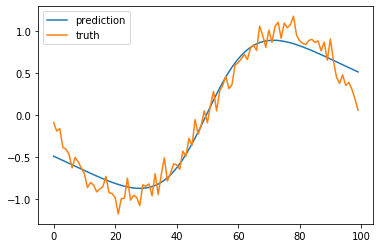

In [ ]:
plt.plot(A.squeeze(),label='prediction')
plt.plot(y.squeeze(),label='truth')
plt.legend()

In [ ]:

#### linear model
model = NeuralNetwork(loss='mean-square-error')
#model.addLayer(inputDimension=1, units=10, activation='tanh')

model.addLayer(inputDimension=1, units=1, activation='')
model


num_iterations = 100000
for ix in range(num_iterations):
    A = model.forward(X)
    model.backward(A, Y)
    model.update()
    if ix % 10000 == 0:
        print('cost:', model.cost(Y, A))

cost: 0.5118159993370451
cost: 0.18015951975248823
cost: 0.18015951975248823
cost: 0.18015951975248823
cost: 0.18015951975248823
cost: 0.18015951975248823
cost: 0.18015951975248823
cost: 0.18015951975248823
cost: 0.18015951975248823
cost: 0.18015951975248823


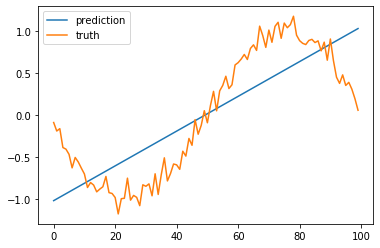

In [ ]:
plt.plot(A.squeeze(),label='prediction')
plt.plot(y.squeeze(),label='truth')
plt.legend()

In [ ]:
#export  

class DropoutLayer(DenseLayer):

    
    def forward(self, A):
        """
        Forward pass through layer
          A: input vector
        """
        Z = np.dot(self.weights, A) + self.bias
        self.prevZ = Z
        self.prevA = A
        A = self.activationForward(Z)
        
        # drop out activations
        #print(f'previous activation: {self.prevA.shape}')
        #print('activation '+ str(A.shape))
        #print('weights' + str(self.weights.shape))
        
        dropout_percent = 0.5
        
        
        A *= np.random.binomial([np.ones((A.shape))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))
        #print('activation '+ str(A.shape))

        return A
    
    def __repr__(self):
        """
        Used to print a pretty summary of the layer
        """
        act = 'none' if self.activation == '' else self.activation
        return f'Dropout layer (nx={self.weights.shape[1]}, nh={self.weights.shape[0]}, activation={act})'
    
    
    
class AttentionDropoutLayer(DenseLayer):

    
    def forward(self, A, attention):
        """
        Forward pass through layer
          A: input vector
        """
        Z = np.dot(self.weights, A) + self.bias
        self.prevZ = Z
        self.prevA = A
        A = self.activationForward(Z)
        
        # drop out activations
        #print(f'previous activation: {self.prevA.shape}')
        #print('activation '+ str(A.shape))
        #print('weights' + str(self.weights.shape))
        
        dropout_percent = 0.5
        
        
        #A *= np.random.binomial([np.ones((A.shape))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))
        A *= attention
        #print('activation '+ str(A.shape))

        return A
    
    def __repr__(self):
        """
        Used to print a pretty summary of the layer
        """
        act = 'none' if self.activation == '' else self.activation
        return f'Attention Dropout layer (nx={self.weights.shape[1]}, nh={self.weights.shape[0]}, activation={act})'
   
    
class DropoutLayer(DenseLayer):

    
    def forward(self, A):
        """
        Forward pass through layer
          A: input vector
        """
        dropout_percent = 0.5

        dropout_weights = self.weights * np.random.binomial([np.ones((self.weights.shape))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))
        #print(dropout_weights)
        Z = np.dot(dropout_weights, A) + self.bias
        self.prevZ = Z
        self.prevA = A
        A = self.activationForward(Z)
        
        # drop out activations
        #print(f'previous activation: {self.prevA.shape}')
        #print('activation '+ str(A.shape))
        #print('weights' + str(self.weights.shape))
        
        
        
        #A *= np.random.binomial([np.ones((A.shape))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))
        #print('activation '+ str(A.shape))

        return A
    
    def __repr__(self):
        """
        Used to print a pretty summary of the layer
        """
        act = 'none' if self.activation == '' else self.activation
        return f'Dropout layer (nx={self.weights.shape[1]}, nh={self.weights.shape[0]}, activation={act})'
    
    
class AttentionDropoutLayer(DenseLayer):

    
    def forward(self, A, attention):
        """
        Forward pass through layer
          A: input vector
        """
        
        attention_sparsity = np.mean(attention)
        weight_scaling = 1
        if attention_sparsity !=1:
            weight_scaling = (1.0/(1-attention_sparsity))
        
        attention_weights = self.weights* attention * weight_scaling
        Z = np.dot(attention_weights, A) + self.bias
        self.prevZ = Z
        self.prevA = A
        A = self.activationForward(Z)
        
        # drop out activations
        #print(f'previous activation: {self.prevA.shape}')
        #print('activation '+ str(A.shape))
        #print('weights' + str(self.weights.shape))
        
        #dropout_percent = 0.5
        
        
        #A *= np.random.binomial([np.ones((A.shape))],1-dropout_percent)[0] * (1.0/(1-dropout_percent))
        #A *= attention
        #print('activation '+ str(A.shape))

        return A
    
    def __repr__(self):
        """
        Used to print a pretty summary of the layer
        """
        act = 'none' if self.activation == '' else self.activation
        return f'Attention Dropout layer (nx={self.weights.shape[1]}, nh={self.weights.shape[0]}, activation={act})'



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


In [ ]:
model = NeuralNetwork(loss='mean-square-error')
model.addLayer(inputDimension=1, units=10, activation='tanh')

model.addLayer( units=10, activation='tanh',layer_type = DropoutLayer)

model.addLayer( units=1, activation='',)
model

num_iterations = 10
num_iterations = 100000
for ix in range(num_iterations):
    # minibatch
    X_train, X_test, Y_train, y_test = train_test_split(X.T, Y.T, test_size=0.7, random_state=42)
    X_train = X_train.T
    Y_train = Y_train.T
    #X_train, Y_train = shuffle(X,Y)

    A = model.forward(X_train)
    model.backward(A, Y_train)
    model.update()
    if ix % (num_iterations/10) == 0:
        print('cost:', model.cost(Y_train, A))

cost: 0.5299664854347996


KeyboardInterrupt: 

In [ ]:
Y_train.shape

In [ ]:
X_train.shape

(1, 30)

ensemble prediction cost: 0.06386990539137266


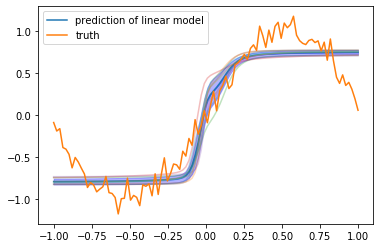

In [ ]:
num_predictive_samples = 10

predictive_sample_list = []

for i in range(num_predictive_samples):
    predictive_sample_list += [model.forward(X).squeeze()]


pred_mean = np.mean(predictive_sample_list,0)
pred_std = np.std(predictive_sample_list,0)

mean_prediction_cost = model.cost(Y,pred_mean)

print(f'ensemble prediction cost: {mean_prediction_cost}')


plt.plot(X.squeeze(),pred_mean,label='prediction of linear model')
plt.fill_between(X.squeeze(), pred_mean, pred_mean - pred_std, alpha = 0.3,color='blue')
plt.fill_between(X.squeeze(), pred_mean, pred_mean + pred_std, alpha = 0.3,color='blue')

for sample in predictive_sample_list:
    plt.plot(X.squeeze(), sample,alpha=0.3)

plt.plot(X.squeeze(),y.squeeze(),label='truth')
plt.legend()

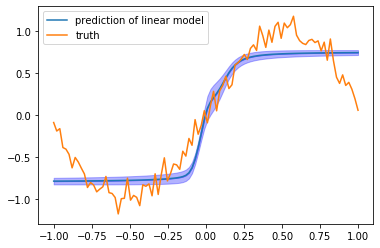

In [ ]:
num_predictive_samples = 10

predictive_sample_list = []

for i in range(num_predictive_samples):
    predictive_sample_list += [model.forward(X).squeeze()]



pred_mean = np.mean(predictive_sample_list,0)
pred_std = np.std(predictive_sample_list,0)

plt.plot(X.squeeze(),pred_mean,label='prediction of linear model')
plt.fill_between(X.squeeze(), pred_mean, pred_mean - pred_std, alpha = 0.3,color='blue')
plt.fill_between(X.squeeze(), pred_mean, pred_mean + pred_std, alpha = 0.3,color='blue')

plt.plot(X.squeeze(),y.squeeze(),label='truth')
plt.legend()

In [ ]:

from nbdev.export import *
notebook2script()

Converted 00_abstractions.ipynb.
Converted 01_multi_armed_bandits.ipynb.
Converted 02_models.ipynb.
Converted 03_ensembles.ipynb.
Converted 04_solvers.ipynb.
Converted 05_bayesian_regression.ipynb.
Converted 06_network_with_thompson_attention.ipynb.
Converted 99_helpers.ipynb.
Converted contextual_bandits.ipynb.
Converted index.ipynb.
Converted linear_problem_setup.ipynb.
Converted noncontextual_bandits.ipynb.
Converted nonlinear_bandits.ipynb.


In [ ]:
seed = 0

In [ ]:
seed += 1

np.random.seed(seed)
seed

4

In [ ]:
model = NeuralNetwork(loss='mean-square-error',randomMultiplier=1)

model.addLayer(inputDimension=1, units=10, activation='tanh')#,layer_type = DropoutLayer)

model.addLayer( units=9, activation='tanh')




model.addLayer( units=1, activation='tanh',layer_type = AttentionDropoutLayer)

model.addLayer( units=9, activation='tanh')




model.addLayer( units=1, activation='',layer_type = AttentionDropoutLayer)
model





[
  1 -> Dense layer (nx=1, nh=10, activation=tanh)
  2 -> Dense layer (nx=10, nh=9, activation=tanh)
  3 -> Attention Dropout layer (nx=9, nh=1, activation=tanh)
  4 -> Dense layer (nx=1, nh=9, activation=tanh)
  5 -> Attention Dropout layer (nx=9, nh=1, activation=none)
]

In [ ]:
model.layers[1].weights.shape

(9, 10)

In [ ]:
X = np.atleast_2d(np.linspace(-1,1,100))
attention = np.ones(model.layers[2].weights.shape)

dropout_percent = 0.5

attention = np.random.binomial([np.ones((model.layers[2].weights.shape))],1-dropout_percent)[0]#.shape
attention

array([[0, 0, 0, 1, 0, 0, 1, 1, 1]])

In [ ]:
#attention = np.array([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [ ]:
yhat = []

for x in X.T:
    yhat += [model.forward(np.atleast_2d(x), attention)]

yhat = np.array(yhat)

In [ ]:
np.mean(attention)

0.4444444444444444

In [ ]:
attention

array([[0, 0, 0, 1, 0, 0, 1, 1, 1]])

In [ ]:
x.shape, yhat.shape

((1,), (100, 1, 1))

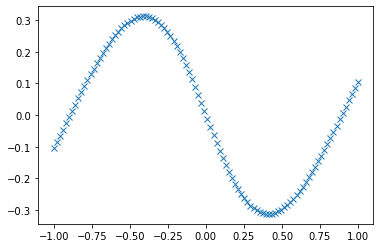

In [ ]:
plt.plot(X.squeeze(), yhat.squeeze(),'x')

In [ ]:
attention = np.ones(model.layers[2].weights.shape)


In [ ]:
yhat_full = []

for x in X.T:
    yhat_full += [model.forward(np.atleast_2d(x), attention)]

yhat_full = np.array(yhat_full)

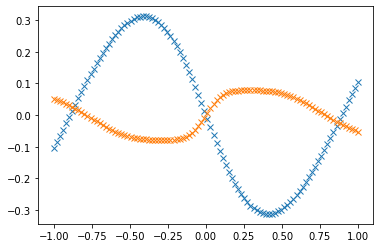

In [ ]:
plt.plot(X.squeeze(), yhat.squeeze(),'x')
plt.plot(X.squeeze(), yhat_full.squeeze(),'x')